In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf

In [3]:
import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from skimage.transform import resize
from sklearn.model_selection import train_test_split

/Users/vetlebh/miniconda3/envs/model/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence
/Users/vetlebh/miniconda3/envs/model/lib/python3.7/site-packages/sklearn/model_selection/_split.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/Users/vetlebh/miniconda3/envs/model/lib/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence


In [5]:
from network import get_model
from scipy.interpolate import BSpline
from cv2 import floodFill

In [18]:
from spline import Spline

### Generate Data

In [6]:
im_height = 256
im_width = 256

checkpoint_path = 'weights_1.h5'
model_path = 'model_1.h5'

epochs = 1
batch_size = 1

training_path = 'training.nosync'
img_name = 'image.npy'
gt_name = 'gt.npy'

test_size = 0.1
val_size = 0.1
random_state = 69

max_slices = 15





walk = next(os.walk(training_path))[1]

X = np.zeros((len(walk)*max_slices, im_height, im_width, 1))
y = np.zeros((len(walk)*max_slices, im_height, im_width, 1))

img_nr = 0
sum_slices = 0
patients_not_found = 0
for ids in walk[:10]:
    
    try:
        img = np.load(os.path.join(training_path, ids, img_name))
        gt = np.load(os.path.join(training_path, ids, gt_name))
        slices = img.shape[2]
        
        for slice_nr in range(slices):
            
            img_slice, gt_slice = img[:, :, slice_nr], gt[:, :, slice_nr]
            img_resized = resize(img_slice, (im_height, im_width, 1), mode = 'edge', preserve_range = True, anti_aliasing=True)
            gt_resized = resize(gt_slice, (im_height, im_width, 1), mode = 'edge', preserve_range = True, anti_aliasing=True)
            
            # We are only interested in the classes 'heart' and 'background' for this experiment
            gt_resized = (gt_resized > 0.5).astype(np.uint8)
        
            X[sum_slices, :, :, :] = img_resized/255.0
            y[sum_slices, :, :, :] = gt_resized
            
            sum_slices +=1
     
    except:
        print(f'{ids} not found')
        patients_not_found += 1
        continue
    
    if(img_nr%10 == 0):
        print(f'{img_nr} images and {sum_slices} slices loaded to array')
    img_nr += 1
print(f'Image load complete. {img_nr} images and {sum_slices} slices loaded successfully. ')

0 images and 9 slices loaded to array
Image load complete. 10 images and 85 slices loaded successfully. 


In [7]:
X, y = X[:sum_slices, :, :, :], y[:sum_slices, :, :, :]
print(X.shape, y.shape)
print(np.unique(y))

# Split train data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# Split train data into train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=val_size, random_state=random_state)

print(f'Training size: {X_train.shape[0]}, Validation size: {X_valid.shape[0]}, Test size: {X_test.shape[0]}')

(85, 256, 256, 1) (85, 256, 256, 1)
[0. 1.]
Training size: 68, Validation size: 8, Test size: 9


In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

### Help functions

In [16]:


def calc_intersect(point):
    #cell_height = point[1]-int(point[1])
    #return cell_height*255.0
    return 1.0


def floodFill_start(img, row, c):
    """
    Iterates outwards from start row to find point satisfied by
    ray-casting algortihm to be inside spline
    """
    if (row >= 256 or row < 0):
        return False
    next_row = int(row + 10*c)
    c_abs = np.abs(c)
    c = (-1)**c_abs * (c_abs+1)
    intersect = np.where(img[row, :] > 0.0)[0]
    nr_intersect = intersect.shape[0]
    if (nr_intersect > 1):
        for i in range (0, nr_intersect-1, 2):
            if (intersect[i+1]-intersect[i] > 1):
                return (int((intersect[i+1]+intersect[i])/2), row)
        return floodFill_start(img, next_row, c)
    else:
        return floodFill_start(img, next_row, c)


def get_spline_img(p, batch_size, n):

    d = 3
    nd = n+d
    rows = 256
    cols = 256
    
    img_batch = np.zeros((batch_size, rows, cols))
    
    for i in range(batch_size):
        p_i = p[i, :].reshape(n, 2)
        p_temp = np.zeros((nd,2))
        p_temp[:n] = p_i
        p_temp[n:] = p_i[:d]
        p_i = p_temp

        t = np.linspace(0, 1, nd+d+1)
        spline = BSpline(t, p_i, d, 'periodic')

        # Calculate step size
        """
        Based on theroretical estimate, see report
        """
        step = 1/((nd+d)*np.max(np.sum(p_i, axis=0)))
        #print(f'stepsize = {step}')

        img = np.zeros((rows, cols))
        t_n = np.linspace(0, 1, int(1.0/step))
        for x in t_n:
            point = spline(x)
            col = int(point[0])
            row = int(point[1])
            if img[row, col] == 0:
                img[row, col] = calc_intersect(point)

        img = img.astype('uint8')
        
        start_ind = floodFill_start(img, 128, 1)
        if not start_ind:
            img[:,:] = 0
        else:
            img = floodFill(img, None, start_ind, 1.0)[1]
        
        img_batch[i, :, :] = img

    return img_batch

In [10]:

@tf.custom_gradient
def spline_loss(p_pred, y):
    
    y = tf.squeeze(y)
    
    # Logit default is False, should be True?
    bce = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.SUM)
    
    p = p_pred.numpy() # Transform input tensor to numpy-array
    batch_size, output_size = p.shape[0], p.shape[1]
    n = int(output_size/2)  # n is number of control points
    y_pred = tf.constant(get_spline_img(p, batch_size, n), dtype='float32')  # Draw spline from control points
    #ce = bce(y, y_pred).numpy().sum() # Calculate Binary Crossentropi loss
    ce = bce(y, y_pred) # Calculate Binary Crossentropi loss
    #print('pshape: ', p.shape)
    def spline_grad(dLoss):
        
        dP = 0.1
        gradient = np.zeros((batch_size, output_size))
        
        # Iterate over all samples in batch
        for sample in range(batch_size):
        
            # Iterate over all control points to calculate gradient
            for i in range(n):

                # Calculate change in loss by increasing cp i by dx
                Pi_dx = p[None, sample, :].copy()
                if (Pi_dx[:, 2*i] < 256.0 - dP):
                    Pi_dx[:, 2*i] = Pi_dx[:, 2*i] + dP
                Pi_dx_loss = bce(y, tf.constant(get_spline_img(Pi_dx, 1, n), dtype='float32'))
                dLoss_dPi_x = (Pi_dx_loss - ce)/dP 


                # Calculate change in loss by increasing cp i by dy
                Pi_dy = p[None, sample, :].copy()
                if (Pi_dy[:, 2*i] < 256.0 - dP):
                    Pi_dy[:, 2*i+1] = Pi_dy[:, 2*i+1] + dP
                Pi_dy_loss = bce(y, tf.constant(get_spline_img(Pi_dy, 1, n), dtype='float32'))
                dLoss_dPi_y = (Pi_dy_loss - ce)/dP


                # Create gradient consisting of dx, dy for each cp
                gradient[sample, 2*i] = dLoss_dPi_x
                gradient[sample, 2*i+1] = dLoss_dPi_y
                
        gradient = dLoss * tf.constant(gradient, dtype='float32')
        return gradient, None

    return ce, spline_grad
    


def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

def loss(model, x, y, training):
    p_pred = model(x, training=training)
    return spline_loss(p_pred, y)


#y = tf.zeros((2, 256, 256), dtype='float32')
#x = tf.ones((2, 256, 256), dtype='float32')

#l, _ = spline_loss(model, x, y, training=False)
#print("Loss test: {}".format(l))

### Model

In [11]:

model = get_model()

In [14]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

loss_value, grads = grad(model, X_train, y_train)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, X_train, y_train, training=True).numpy()))

stepsize = 4.74338053975283e-05
stepsize = 5.3123708241960683e-05
stepsize = 4.939263071268918e-05
stepsize = 5.606871661986568e-05
stepsize = 5.31405878307168e-05
stepsize = 4.9418062350652236e-05
stepsize = 4.887527985125613e-05
stepsize = 3.927453717678527e-05
stepsize = 4.1239487176399024e-05
stepsize = 5.2851579418127355e-05
stepsize = 4.18582011282221e-05
stepsize = 4.8544324642639155e-05
stepsize = 4.577217320959172e-05
stepsize = 4.4359440140068475e-05
stepsize = 4.482128797358441e-05
stepsize = 4.9209388542523916e-05
stepsize = 4.5053153455882086e-05
stepsize = 4.521496518571781e-05
stepsize = 4.4505464544800124e-05
stepsize = 4.2813860987488876e-05
stepsize = 4.35431329562157e-05
stepsize = 4.336064507521054e-05
stepsize = 4.9190010935331384e-05
stepsize = 4.1999705720720376e-05
stepsize = 4.559089150656309e-05
stepsize = 4.492507129703663e-05
stepsize = 4.3689038598284055e-05
stepsize = 4.767568913792454e-05
stepsize = 5.414782044856965e-05
stepsize = 6.768391075824681e-05
s

stepsize = 4.8537726792695776e-05
stepsize = 4.8544324642639155e-05
stepsize = 4.8537726792695776e-05
stepsize = 4.8544324642639155e-05
stepsize = 4.85410254934673e-05
stepsize = 4.8544324642639155e-05
stepsize = 4.85410254934673e-05
stepsize = 4.8544324642639155e-05
stepsize = 4.854102574513994e-05
stepsize = 4.8544324642639155e-05
stepsize = 4.8541025697951317e-05
stepsize = 4.8544324642639155e-05
stepsize = 4.85410254934673e-05
stepsize = 4.577217320959172e-05
stepsize = 4.5766307346218044e-05
stepsize = 4.577217320959172e-05
stepsize = 4.5766307346218044e-05
stepsize = 4.577217320959172e-05
stepsize = 4.5766307793663246e-05
stepsize = 4.577217320959172e-05
stepsize = 4.5769240089960135e-05
stepsize = 4.577217320959172e-05
stepsize = 4.5769240089960135e-05
stepsize = 4.577217320959172e-05
stepsize = 4.5769240089960135e-05
stepsize = 4.577217320959172e-05
stepsize = 4.576924025777359e-05
stepsize = 4.577217320959172e-05
stepsize = 4.5769240089960135e-05
stepsize = 4.4359440140068475e

stepsize = 4.3686366373708954e-05
stepsize = 4.3689038598284055e-05
stepsize = 4.3686366373708954e-05
stepsize = 4.3689038598284055e-05
stepsize = 4.3686366539336794e-05
stepsize = 4.3689038598284055e-05
stepsize = 4.3686366373708954e-05
stepsize = 4.767568913792454e-05
stepsize = 4.766932576474499e-05
stepsize = 4.767568913792454e-05
stepsize = 4.766932527931554e-05
stepsize = 4.767568913792454e-05
stepsize = 4.766932576474499e-05
stepsize = 4.767568913792454e-05
stepsize = 4.767250699624031e-05
stepsize = 4.767568913792454e-05
stepsize = 4.767250699624031e-05
stepsize = 4.767568913792454e-05
stepsize = 4.767250699624031e-05
stepsize = 4.767568913792454e-05
stepsize = 4.767250718967943e-05
stepsize = 4.767568913792454e-05
stepsize = 4.767250699624031e-05
stepsize = 5.414782044856965e-05
stepsize = 5.4139612256208546e-05
stepsize = 5.414782044856965e-05
stepsize = 5.413961163005855e-05
stepsize = 5.414782044856965e-05
stepsize = 5.413961163005855e-05
stepsize = 5.414782044856965e-05
st

stepsize = 4.307007282988565e-05
stepsize = 4.3075267464359807e-05
stepsize = 4.3070072433608244e-05
stepsize = 4.3075267464359807e-05
stepsize = 4.307007282988565e-05
stepsize = 4.3075267464359807e-05
stepsize = 4.307266979233977e-05
stepsize = 4.3075267464359807e-05
stepsize = 4.307266979233977e-05
stepsize = 4.3075267464359807e-05
stepsize = 4.307266979233977e-05
stepsize = 4.3075267464359807e-05
stepsize = 4.3072669940961725e-05
stepsize = 4.3075267464359807e-05
stepsize = 4.307266979233977e-05
stepsize = 4.266900818404937e-05
stepsize = 4.26639106780304e-05
stepsize = 4.266900818404937e-05
stepsize = 4.2663911066869063e-05
stepsize = 4.266900818404937e-05
stepsize = 4.26639106780304e-05
stepsize = 4.266900818404937e-05
stepsize = 4.266645927878582e-05
stepsize = 4.266900818404937e-05
stepsize = 4.266645927878582e-05
stepsize = 4.266900818404937e-05
stepsize = 4.266645947322838e-05
stepsize = 4.266900818404937e-05
stepsize = 4.266645942461774e-05
stepsize = 4.266900818404937e-05
st

stepsize = 4.9353780976335874e-05
stepsize = 4.935719153411591e-05
stepsize = 4.935378123650692e-05
stepsize = 4.935719153411591e-05
stepsize = 4.935378118772485e-05
stepsize = 4.935719153411591e-05
stepsize = 4.935378123650692e-05
stepsize = 4.518255700933183e-05
stepsize = 4.5176841285913725e-05
stepsize = 4.518255700933183e-05
stepsize = 4.5176841285913725e-05
stepsize = 4.518255700933183e-05
stepsize = 4.5176841285913725e-05
stepsize = 4.518255700933183e-05
stepsize = 4.5179698966847484e-05
stepsize = 4.518255700933183e-05
stepsize = 4.5179698966847484e-05
stepsize = 4.518255700933183e-05
stepsize = 4.517969918487172e-05
stepsize = 4.518255700933183e-05
stepsize = 4.5179699130365656e-05
stepsize = 4.518255700933183e-05
stepsize = 4.5179698966847484e-05
stepsize = 4.656897564038375e-05
stepsize = 4.656290378695968e-05
stepsize = 4.656897564038375e-05
stepsize = 4.656290378695968e-05
stepsize = 4.656897564038375e-05
stepsize = 4.656290378695968e-05
stepsize = 4.656897564038375e-05
st

### Train

In [17]:
## Note: Rerunning this cell uses the same model variables

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 10

for epoch in range(num_epochs):
    epoch_start = time.time()
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    # Training loop - using batches of 32
    for x, y in train_dataset:
        # Optimize the model
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss
        # Compare predicted label to actual label
        # training=True is needed only if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        epoch_accuracy.update_state(y, model(x, training=True))

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    epoch_end = time.time()

    if epoch % 1 == 0:
        print(f"Epoch {epoch}: Loss: {epoch_loss_avg.result()}, Accuracy: {epoch_accuracy.result()}, Epoch time: {epoch_end-epoch_start}")

Epoch 0: Loss: 37370.79296875, Accuracy: 0.0, Epoch time: 422.79042315483093
Epoch 1: Loss: 37370.79296875, Accuracy: 0.0, Epoch time: 420.7995581626892
Epoch 2: Loss: 37370.79296875, Accuracy: 0.0, Epoch time: 424.4978759288788
Epoch 3: Loss: 37370.79296875, Accuracy: 0.0, Epoch time: 401.47293186187744
Epoch 4: Loss: 37370.79296875, Accuracy: 0.0, Epoch time: 419.98246717453003
Epoch 5: Loss: 37370.79296875, Accuracy: 0.0, Epoch time: 406.1558027267456
Epoch 6: Loss: 37370.79296875, Accuracy: 0.0, Epoch time: 403.587042093277
Epoch 7: Loss: 37370.79296875, Accuracy: 0.0, Epoch time: 403.3357889652252
Epoch 8: Loss: 37370.79296875, Accuracy: 0.0, Epoch time: 402.27748107910156
Epoch 9: Loss: 37370.79296875, Accuracy: 0.0, Epoch time: 425.304771900177


### Evaluate

In [19]:
X_test[0].shape
pred = model(X_test, training=False)

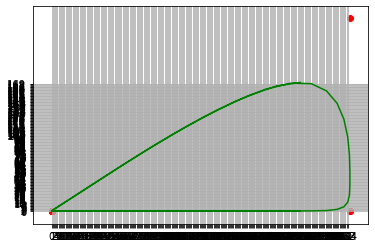

In [27]:
p = pred[0].numpy()
spline = Spline(p)
spline.drawCurve()